#Everything that follows, was tested and run on Google Colab. The excel with the necessary data was uploaded before running the main cell.

The following downloads and imports are needed for the whole project.

In [1]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.5 MB/s eta 0:00:00


In [14]:
import keras
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from keras_tuner.tuners import Hyperband
from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

The following function is used to clean the dataset. Initially, I visually inspected the data to identify inconsistencies and understand the type of each column in the dataset. Additionally, I printed a few rows, the data types for each column, and the statistics. Subsequently, I checked the dataset for null entries and attempted to fill them using a KNN Imputer for appropriate answers. If the imputation failed due to many consecutive rows containing missing values, I removed them. Another solution I considered was checking the column descriptions for keywords like 'rain' or 'snow' and using them to populate the 'Precip Type' column.


In [15]:
def read_file():
	# Load the dataset.
	weather_data = pd.read_csv('./interview_dataset.csv')

	# Exploratory Data Analysis.
	print(weather_data.head())  # View the first few rows of the dataset.
	print(weather_data.info())  # Check data types and missing values.
	print(weather_data.describe())  # Summary statistics.

	# Check for missing values.
	missing_values = weather_data.isnull().sum()
	print("Missing Values:", missing_values)

	# Check and remove outliers.
	weather_data = remove_outliers(weather_data)

	# Drop rows where the imputer didn't have sufficient data.
	weather_data = weather_data.dropna()

	# Replace the original column with the imputed values
	weather_data['Precip Type'], label_encoder = data_imputation(weather_data)

	# Check for missing values.
	missing_values = weather_data.isnull().sum()
	print("Missing Values After Clean Up:", missing_values)

	# Save the DataFrame to a CSV file
	weather_data.to_csv('./updated_dataset.csv', index=False)

	return weather_data, label_encoder


The following function uses KNN data imputation. The main principle of this algorithm is to leverage the information from neighboring data points surrounding the missing values to infer and impute the missing data. Adding -1 to every NaN value to remove it later.

In [16]:
def data_imputation(weather_data):
	# Check the column names in the DataFrame
	print(weather_data.columns)

	# Assuming the column name is 'Precip Type', use the correct column name from your DataFrame
	column_with_missing = weather_data['Precip Type']  # Ensure 'Precip Type' is the correct column name

	# Label encode the categorical column
	label_encoder = LabelEncoder()
	column_with_missing_encoded = label_encoder.fit_transform(column_with_missing.astype(str))  # Ensure column values are converted to strings

	# Convert the encoded column to a DataFrame
	df = pd.DataFrame(column_with_missing_encoded, columns=['Precip Type'])

	# Reshape the column to 2D array
	column_with_missing_2d = df['Precip Type'].values.reshape(-1, 1)

	# Initialize the KNNImputer with k neighbors
	imputer = KNNImputer(n_neighbors=2, weights="uniform")

	# Impute missing values using KNN imputation
	imputed_column_2d = imputer.fit_transform(column_with_missing_2d)

	# Flatten the imputed column back to 1D array
	imputed_column = imputed_column_2d.flatten()

	return imputed_column, label_encoder

The following function finds 1st quantile and 3rd quantile of each numerical column. Afterwards, it calculates the IQR and the upper/lower bound based on a threshold. If the value is lower than the lower bound or higher than the upper bound the row is removed.

In [17]:
def remove_outliers(df, threshold=1.5):
    numeric_columns = df.select_dtypes(include=['number']).columns

    for column in numeric_columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    return df

The following function is used to visualize the distribution and correlation among the dataset's features. Upon examining the correlation matrix, it becomes clear which features hold greater significance, and which class serves as our label.

In [18]:
def visualize_correlation(weather_data):
	# Visualize the distribution of numerical features
	sns.pairplot(weather_data, diag_kind='kde')
	plt.show()

	# Correlation analysis
	correlation_matrix = weather_data.corr(numeric_only=True)
	plt.figure(figsize=(12, 8))
	sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
	plt.title('Correlation Matrix')
	plt.show()

After reviewing the correlation matrix, I proceeded with a more in-depth analysis using classifiers to determine feature importance. Subsequently, I removed columns containing text and determined the total number of classes. The use of different algorithms yielded two distinct sets of results. Both sets will be considered to determine which features yield the optimal model performance.

In [34]:
def get_feature_importance(weather_data):
	# Number of classes
	num_classes = 1

	weather_data = weather_data.drop(columns=['Summary', 'Daily Summary'])
	# Separate features (X) and target variable (y)
	X = weather_data.drop(columns=['Apparent Temperature (C)'])  # Features
	y = weather_data['Temperature (C)']  # Target variable

	# Split the data into training and testing sets
	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

	# 1. Feature Importance from Tree-based Models
	# Train a Random Forest classifier to obtain feature importance
	rf = RandomForestRegressor(n_estimators=100, random_state=42)
	rf.fit(X_train, y_train)

	# Get feature importance scores
	feature_importance = rf.feature_importances_
	feature_names = X.columns

	# Select features with importance above a certain threshold
	threshold = 0.05  # Example threshold
	selected_features_rf = feature_names[feature_importance > threshold]

	# 2. Recursive Feature Elimination (RFE)
	# Initialize RFE with a RandomForestRegressor
	rfe = RFE(estimator=RandomForestRegressor(n_estimators=100, random_state=42), n_features_to_select=5)
	rfe.fit(X_train, y_train)

	# Get selected features from RFE
	selected_features_rfe = feature_names[rfe.support_]

	# Print selected features
	print("Selected Features from Random Forest Feature Importance:")
	print(selected_features_rf)
	print("\nSelected Features from Recursive Feature Elimination (RFE):")
	print(selected_features_rfe)

	# Drop columns not in the list
	columns_to_drop = [col for col in X.columns if col not in selected_features_rf]
	rf_data = X.drop(columns=columns_to_drop)

	# Drop columns not in the list
	columns_to_drop = [col for col in X.columns if col not in selected_features_rfe]
	rfe_data = X.drop(columns=columns_to_drop)

	return num_classes, rf_data, rfe_data

Normalize each column of the features

In [9]:
def normalize(data):
    data_mean = data.mean(axis=0)
    data_std = data.std(axis=0)
    return (data - data_mean) / data_std

Get extracted features

In [36]:
def get_features(weather_data, features):
    feature_data = pd.DataFrame()
    for feature in features:
      print(feature)
      feature_data = pd.concat([feature_data, weather_data[feature]], axis=1)
    return feature_data

For the model I decided on using a Long-Short Memomry Model (LSTM). It is a really common neural model for Time-Series data. A few alternative algorithms that could be used are Autoregressive Integrated Moving Average (ARIMA) and Seasonal Autoregressive Integrated Moving-Average (SARIMA). All of the have their pros and cons, but LSTM with our current size was a more optimal choice in my opinion, even if it is more computationally expensive. For the hyperparameters of the model, I used the tuner to try and test different values to get the optimal hyper-parameters. The tuner only has to run one time, giving us the result and saving them to a directory to be re-used.

After getting the best model predicted by the tuner, we train it for 100 epochs (I believe that around 50 to 100 would be a great selection) and plot the training history of the model.

In [63]:
def run_model(inputs, dataset_val, epochs):
	inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
	lstm_out = keras.layers.LSTM(32)(inputs)
	outputs = keras.layers.Dense(1)(lstm_out)

	model = keras.Model(name="Weather_forcaster",inputs=inputs, outputs=outputs)
	model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
	model.summary()

	history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val
	)

	loss = history.history["loss"]
	epochs = range(len(loss))
	plt.figure()
	plt.plot(epochs, loss, "b", label="Training loss")
	plt.title("Training Loss")
	plt.xlabel("Epochs")
	plt.ylabel("Loss")
	plt.show()

	return model, history

I've designed the following function to iterate through each column. If a column contains numerical data, the function generates new synthetic data. It calculates the mean and standard deviation of each numerical column and generates a new value using a Gaussian distribution centered around the calculated mean with the standard deviation as the spread. These synthetic data points are then added to a new row for prediction.

In [12]:
def generate_data(df, num_rows=48):
    new_rows = []
    for _ in range(num_rows):
        new_row = {}
        for column in df.select_dtypes(include=['number']).columns:
            # Get mean and standard diviation
            mean = df[column].mean()
            std = df[column].std()

            # Generate random data with gaussian distribution.
            synthetic_value = np.random.normal(mean, std)
            new_row[column] = synthetic_value
        new_rows.append(new_row)
    new_df = pd.DataFrame(new_rows)
    return new_df

The following code is to run the code, split the train data to validation and train data. Finally, running and testing the model using the generated data.

Selected Features from Random Forest Feature Importance:
Index(['Temperature (C)'], dtype='object')

Selected Features from Recursive Feature Elimination (RFE):
Index(['Precip Type', 'Temperature (C)', 'Wind Speed (km/h)',
       'Wind Bearing (degrees)', 'Pressure (millibars)'],
      dtype='object')
Precip Type
Temperature (C)
Wind Speed (km/h)
Wind Bearing (degrees)
Pressure (millibars)
TEST!           0         1         2         3         4
0 -0.278877 -0.113996  0.540185  0.069523 -0.637813
1 -0.278877 -0.193240  0.186553 -0.138369 -0.692516
2 -0.278877 -0.245868  0.722994 -0.227465 -0.768710
3 -0.278877 -0.117021  0.189550 -0.098770 -0.856625
4 -0.278877 -0.013579  0.959748 -0.029473 -0.868348
Model: "Weather_forcaster"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 2, 5)]            0         
                                                                

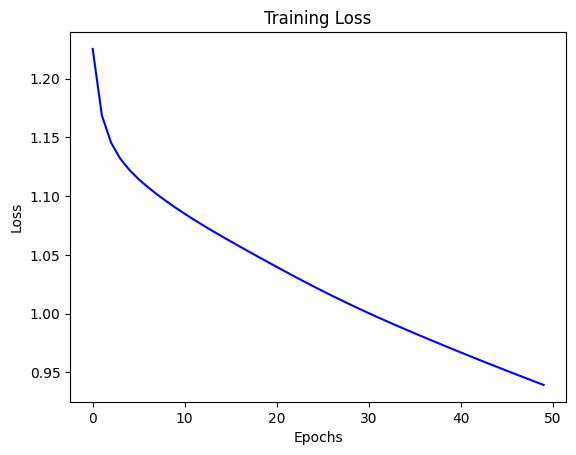

2/2 [==============================] - 0s 5ms/step


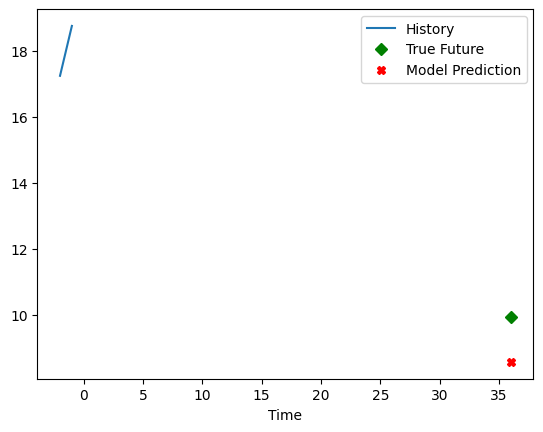

In [72]:
import time

if __name__ == "__main__":
	weather_data, label_encoder = read_file()

	# Set dates as indices
	weather_data.set_index('Formatted Date', inplace=True)

	# Visualise the correlation
	# visualize_correlation(weather_data)
	num_classes, selected_features_rf, selected_features_rfe = get_feature_importance(weather_data)
	weather_data = weather_data.drop(columns=['Summary', 'Daily Summary'])

	# Get features and create the new dataset
	features = get_features(weather_data, selected_features_rfe)
	features = normalize(features.values)
	features = pd.DataFrame(features)
	print('TEST!', features.head())
	time.sleep(10)
	# Get train-validation sets.
	training_size = int(0.8 * features.shape[0])
	train_data = features.loc[0 : training_size - 1]
	val_data = features.loc[training_size:]

	# Set series to read each time
	epochs = 50
	days = 3
	timestamps = 24
	days_to_predict = 3
	start = days*timestamps + days_to_predict*timestamps
	end = start + training_size

	# Split data
	x_train = train_data.values
	y_train = features.iloc[start:end][[0]]

	# Set sequence length
	sequence_length = int((days*timestamps + days_to_predict*timestamps) / (days_to_predict*timestamps))

	# Set dataset as a timeseries
	dataset_train = tf.keras.preprocessing.timeseries_dataset_from_array(
    data=x_train,
    targets=y_train,
    sequence_length=sequence_length,
    sampling_rate=6,
    batch_size=64,
	)

	# Create validation set
	x_val_end = len(val_data) - start

	label_start = training_size + start

	x_val = val_data.iloc[:x_val_end][[i for i in range(len(features.columns))]].values
	y_val = features.iloc[label_start:][[0]]

	dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=6,
    batch_size=64,
	)

	# Get batch
	for batch in dataset_train.take(1):
		inputs, targets = batch

	model, history_data = run_model(inputs, dataset_val, epochs)

	temp_mean = weather_data['Temperature (C)'].mean(axis=0)
	temp_std = weather_data['Temperature (C)'].std(axis=0)

	for x, y in dataset_val.skip(12):
		history_data = x[0][:, 1].numpy() * temp_std + temp_mean
		true_value = y[0].numpy() * temp_std + temp_mean
		prediction = model.predict(x)[0] * temp_std + temp_mean
		time_steps = list(range(-(history_data.shape[0]), 0))
		plt.plot(time_steps, history_data)
		plt.plot(36, true_value, "gD")
		plt.plot(36, prediction, "rX")
		plt.legend(["History", "True Future", "Model Prediction"])
		plt.xlabel("Time")
		plt.show()
		break


To summarize, given the current dataset I can say with confidence that using the features that were given by the Recursive Feature Elimination where the optimal solution. So, I'll add the generated RFE data to the saved file for further analysis.

The following import and code, is a basic database creation and a simple API to get and post data for further analysis.

In [ ]:
!pip install flask_sqlalchemy

The following code is a simple API call and database creation for keeping and retrieving records. The database table has all the features deemed important from the Recursive Feature Elimination. The GET method retrieves all the data from the database as a JSON file. Finally, the POST method is for adding new data to the table.

In [ ]:
from flask import Flask, jsonify, request
from flask_sqlalchemy import SQLAlchemy
from datetime import datetime, timezone

app = Flask(__name__)
app.config['SQLALCHEMY_DATABASE_URI'] = 'sqlite:///forecast.db'
app.config['SQLALCHEMY_TRACK_MODIFICATIONS'] = False
db = SQLAlchemy(app)

# Create a class for the table in the database
class Forecast(db.Model):
    formatted_date = db.Column(db.String, primary_key=True)
    temperature = db.Column(db.Float, nullable=False)
    apparent_temperature = db.Column(db.Float, nullable=False)
    humidity = db.Column(db.Float, nullable=False)
    visibility = db.Column(db.Float, nullable=False)
    pressure = db.Column(db.Float, nullable=False)
    prediction = db.Column(db.String, nullable=False)

    def __repr__(self):
        return f'<Date {self.formatted_date}: Temp={self.temperature}, Apparent Temperature={self.apparent_temperature}, Humidity={self.humidity}, Visibility={self.visibility}, Pressure={self.pressure}, Prediction={self.prediction}>'


# This function retrieves all forecast records from the database and returns them as JSON data
@app.route('/forecast', methods=['GET'])
def get_forecast():
    with app.app_context():
        forecasts = Forecast.query.all()
        forecast_data = [{'formatted_date': forecast.formatted_date, 'temperature': forecast.temperature, 'apparent_temperature': forecast.apparent_temperature,'humidity': forecast.humidity, 'visibility': forecast.visibility, 'pressure': forecast.pressure, 'prediction': forecast.pred} for forecast in forecasts]
    return jsonify(forecast_data)


# For adding a new forecast record to the database based on the JSON data
@app.route('/forecast', methods=['POST'])
def post_forecast():
    data = request.get_json()
    formatted_date = datetime.strptime(data['formatted_date'], '%Y-%m-%d %H:%M:%S')
    with app.app_context():
        new_forecast = Forecast(formatted_date=formatted_date,
                                apparent_temperature=data['apparent_temperature'],
                                humidity=data['humidity'],
                                visibility=data['visibility'],
                                pressure=data['pressure'],
                                prediction=data['prediction'])
        db.session.add(new_forecast)
        db.session.commit()
    return jsonify({'message': 'Forecast added successfully'}), 201

if __name__ == '__main__':
    with app.app_context():
        db.create_all()
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat
